# IHLT Lab 3: Morphology

**Authors:** *Zachary Parent ([zachary.parent](mailto:zachary.parent@estudiantat.upc.edu)), Carlos Jiménez ([carlos.humberto.jimenez](mailto:carlos.humberto.jimenez@estudiantat.upc.edu))*

### 2024-10-03

**Instructions:**

1. Read all pairs of sentences of the *SMTeuroparl* files of test set within the evaluation framework of the project.
2. Compute their similarities by considering lemmas and Jaccard distance.
3. Compare the results with those in session 2 (*document structure*) in which words were considered.
4. Compare the results with gold standard by giving the pearson correlation between them.
5. Questions (justify the answers):

    - Which is better: words or lemmas?
    - Do you think that could perform better for any pair of texts?


## Notes
- we should compare with previous results
- we should expect better results with lemmas
- we may find counter examples in which words are better than lemmas


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import nltk
from nltk.metrics.distance import jaccard_distance

In [2]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Read data from Google Drive

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# BASE_PATH = '/content/drive/MyDrive/MASTER AI'

In [4]:
# Read data from local file system

BASE_PATH = '.'

In [5]:
assert BASE_PATH is not None, "BASE_PATH is not set"


In [6]:
dt = pd.read_csv(
    f"{BASE_PATH}/test-gold/STS.input.SMTeuroparl.txt", sep="\t", header=None
)
dt.columns = ["s1", "s2"]
gs = pd.read_csv(
    f"{BASE_PATH}/test-gold/STS.gs.SMTeuroparl.txt", sep="\t", header=None
)
dt["gs"] = gs[0]
dt.head()

,s1,s2,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00


In [7]:
# Lemmatization methods
wnl = nltk.stem.WordNetLemmatizer()
def lemmatize_one(word):
  x, pos = nltk.pos_tag([word])[0]
  d = {'NN': 'n', 'NNS': 'n', 
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
  if pos in d:
    return wnl.lemmatize(word, pos=d[pos])
  return x

def lemmatize_many(words):
  return [lemmatize_one(word) for word in words]

In [8]:
# Token pre-processing methods
def remove_non_alnum(tokens):
    return [token for token in tokens if token.isalnum()]

def lower(tokens):
    return [token.lower() for token in tokens]

In [9]:
# Scoring methods
def jaccard_vector(s1, s2):
    return pd.concat([s1, s2], axis=1).apply(lambda x: jaccard_distance(set(x.iloc[0]), set(x.iloc[1])), axis=1)

def score_jaccard_vector(jaccard_vector):
    return pearsonr(gs[0], jaccard_vector)[0]

In [10]:
results = pd.DataFrame(index=['score'])

# Tokenize
s1_tokens = dt['s1'].apply(nltk.word_tokenize)
s2_tokens = dt['s2'].apply(nltk.word_tokenize)
results['tokenize'] = score_jaccard_vector(jaccard_vector(s1_tokens, s2_tokens))

# Lower
s1_lower = s1_tokens.apply(lower)
s2_lower = s2_tokens.apply(lower)
results['lower'] = score_jaccard_vector(jaccard_vector(s1_lower, s2_lower))

# Remove non-alphanumeric
s1_alnum = s1_lower.apply(remove_non_alnum)
s2_alnum = s2_lower.apply(remove_non_alnum)
results['remove_non_alnum'] = score_jaccard_vector(jaccard_vector(s1_alnum, s2_alnum))

# Lemmatize
s1_lemmas = s1_alnum.apply(lemmatize_many)
s2_lemmas = s2_alnum.apply(lemmatize_many)
results['lemmatize'] = score_jaccard_vector(jaccard_vector(s1_lemmas, s2_lemmas))

dt["jaccard"] = jaccard_vector(s1_lemmas, s2_lemmas)
dt["gs"] = gs[0]

print("\033[1mResults after each step:\033[0m")
print()
print(results)


Results after each step:

       tokenize     lower  remove_non_alnum  lemmatize
score -0.450498 -0.462495         -0.490289  -0.495849


<Figure size 1000x600 with 0 Axes>

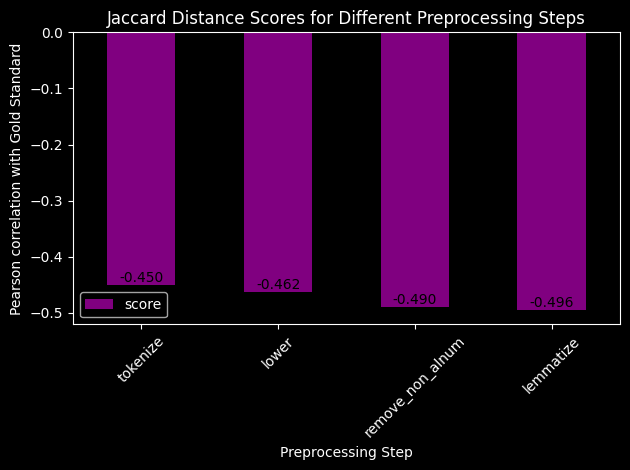

In [11]:
# Plot bar chart
plt.figure(figsize=(10, 6))
results.T.plot(kind='bar', color=['purple'])
plt.title('Jaccard Distance Scores for Different Preprocessing Steps')
plt.xlabel('Preprocessing Step')
plt.ylabel('Pearson correlation with Gold Standard')
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate bar chart values
for i, v in enumerate(results.values[0]):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom', color='black')
plt.show()

/var/folders/0m/k4sjt9f13nq8h9cxt8052ykh0000gn/T/ipykernel_80371/2923686230.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"Pearsonr gs vs jaccard: {results['lemmatize'][0]:.4f}",


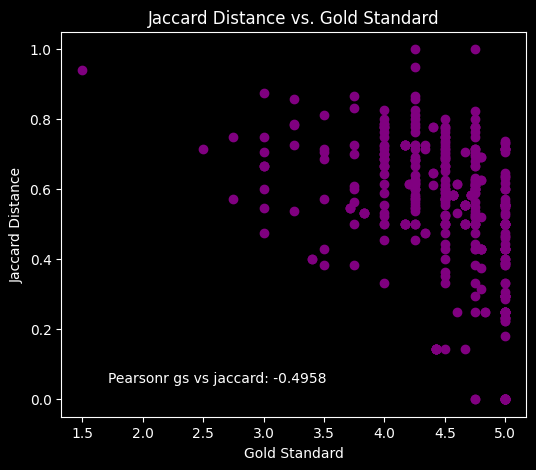

In [12]:
fig = plt.figure(figsize=(6, 5))
ax = plt.axes()

plt.scatter(dt["gs"], dt["jaccard"], color='purple')
plt.xlabel("Gold Standard")
plt.ylabel("Jaccard Distance")
plt.title("Jaccard Distance vs. Gold Standard")
plt.text(
    0.1,
    0.1,
    f"Pearsonr gs vs jaccard: {results['lemmatize'][0]:.4f}",
    transform=ax.transAxes,
    ha="left",
    va="center",
)
plt.show()